$$
\newcommand{\D}{\mathbb{D}}% sphère unité.
\newcommand{\R}{\mathbb{R}}% les réels.
\newcommand{\intervalle}[4]{\mathopen{#1}#2\mathclose{}\mathpunct{};#3\mathclose{#4}}%
\newcommand{\intff}[2]{\intervalle{[}{#1}{#2}{]}}% intervalle fermé.
\newcommand{\intof}[2]{\intervalle{]}{#1}{#2}{]}}% intervalle ouvert-fermé.
\newcommand{\intfo}[2]{\intervalle{[}{#1}{#2}{[}}% intervalle ferme-ouvert.
\newcommand{\intoo}[2]{\intervalle{]}{#1}{#2}{[}}% intervalle ouvert.
\newcommand{\Int}[2]{\intervalle\llbracket{#1}{#2}\rrbracket}% intervalle d'entiers.
\newcommand{\argmax}{\mathop{\mathrm{arg\,max}}}% argmin.
\newcommand{\argmin}{\mathop{\mathrm{arg\,min}}}% argmax.
\newcommand{\eq}{\mathop{\sim}\limits}% équivalent.
\renewcommand{\o}{\mathop{\mathrm{o}}\limits}% petit o.
\renewcommand{\O}{\mathop{\mathrm{O}}\limits}% grand O.
\newcommand{\Card}[1]{\left|#1\right|}% cardinal.
\newcommand{\ens}[1]{\left\{#1\right\}}%
\newcommand{\enstq}[2]{\left\{#1\,\middle/\,#2\right\}}%%t.
$$

# **Projet INF421**

<hr style=height:1px; width:30%; background-color: black; margin-top: -20px;>

### __Projet 3 $-$ _Point clouds : subsampling and neighborhood___ _(proposé par Marc Glisse)_

*Abderrahim BENDAHI*, *Adrien FRADIN*

# **Préliminaires**

## **Imports**

Commençons par importer quelques bibliothèques Python utiles pour ce projet : 

In [312]:
import os

import math

from time import time, sleep

import signal

import random as rd

# Pour créer des files.
from collections import deque

# Pour comparer certaines de nos implémentations avec des fonctions de références.
import numpy as np

# Pour la signatures des fonctions.
from typing import Optional, Callable, Any

# Pour visualiser les jeux de données.
import matplotlib.pyplot as plt

Nous définissons quelques alias améliorer la lisibilité du typage (notament pour la signature des fonctions) : 

In [313]:
Point = list[float, ...]
Ensemble = list[Point]
Graphe = list[list[int]]

## **Fonctions utiles**

Nous écrivons ici quelques fonctions qui nous serons utiles tout au long de ce projet.

Les deux fonctions ci-dessous permettent de calculer la distance euclidienne entre deux points quelconques de $\R^d$, elles seront utiles pour étendre nos programmes au cas $d > 2$.

In [314]:
def diff_squared(x: list[float, float]) -> float:
    '''
        Renvoie la différence au carré entre les flottants x1 et x2.
    '''
    x1, x2 = x
    return (x1 - x2) ** 2

In [315]:
def L2_norm(p1: Point, p2: Point) -> float:
    '''
        Calcul la norme euclidienne entre les points p1 et p2.
    '''
    # Racine carrée de la somme des différences au carrées coordonnées à coordonnées (obtenues avec 'zip').
    return math.sqrt(sum(map(diff_squared, zip(p1, p2))))


# Version plus "classique", avec une boucle 'for' : 
#def L2_norm(p1: list[float, ...], p2: list[float, ...]) -> float:
#    '''
#        Calcul la norme euclidienne entre les points p1 et p2.
#    '''
#    resultat, n = 0, len(p1)
#    for i in range(n):
#        resultat += diff_squared((p1[i], p2[i]))
#    return math.sqrt(resultat)

Voici quelques exemples d'utilisation de ces fonctions avec l'équivalent NumPy en utilisant la fonction ```np.linalg.norm``` : 

In [316]:
# Exemples : 
p1, p2 = [0, 0], [1, 1]
print("Points", p1, "et", p2, ": \nL2_norm :", L2_norm(p1, p2), "   NumPy :", np.linalg.norm(np.array(p1) - np.array(p2)), "\n")

p1, p2 = [0, 0, 0], [1, 1, 1]
print("Points", p1, "et", p2, ": \nL2_norm :", L2_norm(p1, p2), "   NumPy :", np.linalg.norm(np.array(p1) - np.array(p2)), "\n")

p1, p2 = [10, 20, 45, 7], [-87, 0, 12, -87]
print("Points", p1, "et", p2, ": \nL2_norm :", L2_norm(p1, p2), "   NumPy :", np.linalg.norm(np.array(p1) - np.array(p2)))

Points [0, 0] et [1, 1] : 
L2_norm : 1.4142135623730951    NumPy : 1.4142135623730951 

Points [0, 0, 0] et [1, 1, 1] : 
L2_norm : 1.7320508075688772    NumPy : 1.7320508075688772 

Points [10, 20, 45, 7] et [-87, 0, 12, -87] : 
L2_norm : 140.47775624631822    NumPy : 140.47775624631822


La fonction ci-dessous sert à comparer si deux graphes (non orientée, sans multiarêtes) $-$ sous forme de listes d'adjacences $-$ sont égaux : 

In [317]:
def equal_graph(G1: Graphe, G2: Graphe) -> bool:
    '''
        Tester si les graphes G1 et G2 sont égaux.
    '''
    if len(G1) == len(G2):
        # Vérifie si chaque sommet s1 de G1 et son sommet correspondant s2 dans G2 ont les mêmes voisins.
        return all(set(s1) == set(s2) for s1, s2 in zip(G1, G2))
    return False

---

# **1 $-$ Subsampling**

## **1.1 $-$ Basics**

La première version de la tâche $1$ n'utilise pas de file mais une liste de booléens ```couleurs``` indiquant si le point est dans $S$ ou non.

In [318]:
def task_1(P: Ensemble,
           p_1: Point,
           k: int) -> Ensemble:
    '''
        Implémentation naïve (Task 1).
    '''
    # Liste des centres.
    S: Ensemble = [p_1]
    # Matrice (symétrique) des distances mutuelles entre chaque point de P.
    distances = [[L2_norm(x, y) for x in P] for y in P]

    # Liste de booléens : False si le point de P à l'indice i est déja retenu dans S, True s'il est en dehors de S. 
    couleurs = [True] * len(P)
    couleurs[P.index(p_1)] = False # Possibilité d'avoir plusieurs points aux mêmes coordonnées ? (À priori non, mais en pratique... ?).

    # Compléxité temporelle : O(n * k^2)
    for _ in range(k - 1):
        d, i = 0, 0
        # On va chercher le nouveau centre parmis les points de P \ S.
        for j, couleur_j in enumerate(couleurs):
            # Si le point P[j] n'est pas dans S.
            if couleur_j:
                # Pour chaque point qui n'est pas dans S, on cherche sa distance à S.
                distance_a_S = float('inf')
                for couleur_t, dt in zip(couleurs, distances[j]):
                    # Si le point est dans S et à une distance plus courte que celle trouvée jusque-là (distance_a_S), on met à jour les informations.
                    if (not couleur_t) and (distance_a_S > dt):
                        distance_a_S = dt

                # On met à jour si le point P[j] est le plus loin de S trouvé jusque-là.
                if distance_a_S > d:
                    d, i = distance_a_S, j

        # On ajoute le nouveau centre.
        couleurs[i] = False
        S.append(P[i])

    return S

Voici la version de la tâche $1$ telle que décrite dans le rapport en utilisant une file pour maintenir les points de $P \setminus S$ : 

In [319]:
def task_1_queue(P: Ensemble,
                 p_1: Point,
                 k: int) -> Ensemble:
    '''
        Implémentation naïve (Task 1) avec une file pour améliorer (légèrement) 
        la compléxité au niveau des boucles for internes.
    '''
    # Nombre d'éléments de P.
    n = len(P)
    j = P.index(p_1)

    # Liste des indices des centres.
    centres = [j]
    # Matrice (symétrique) des distances mutuelles entre chaque point de P.
    distances = [[L2_norm(x, y) for x in P] for y in P]

    # File des indices des éléments de P \ S.
    points = deque([i for i in range(n) if i != j])
    taille = n - 1

    # Compléxité temporelle : O((n - k) * k^2)
    for _ in range(k - 1):
        d, i = 0, j
        # On va chercher le nouveau centre parmis les points de P \ S.
        for _ in range(taille):
            point = points.popleft()
            # On cherche sa distance à S.
            distance_a_S = float('inf')
            for s in centres:
                # Si le point est à une distance plus courte que celle trouvée jusque-là (distance_a_S), on met à jour les informations.
                dt = distances[point][s]
                if distance_a_S > dt:
                    distance_a_S = dt

            # On met à jour si le point est le plus loin de S trouvé jusque-là.
            if distance_a_S > d:
                if i != j:
                    points.append(i)
                d, i = distance_a_S, point
            else:
                points.append(point)

        # On ajoute le nouveau centre.
        centres.append(i)
        taille -= 1

    S: Ensemble = [P[i] for i in centres]
    return S

## **1.2 $-$ More efficient**

La première version de la tâche $2$ utilise, comme c'était le cas avec la tâche $1$, une liste de booléens ```couleurs``` indiquant si le point est dans $S$ ou non.

In [320]:
def task_2(P: Ensemble,
           p_1: Point,
           k: int) -> Ensemble:
    '''
        Implémentation plus efficiente (Task 2).
    '''
    # Liste des centres.
    S: Ensemble = [p_1]
    # Liste des distances d'un point p de P à S.
    distances_a_S = [L2_norm(p_1, x) for x in P]

    # Liste de booléens : False si le point de P à l'indice i est déja retenu dans S, True s'il est en dehors de S. 
    couleurs = [True] * len(P)
    couleurs[P.index(p_1)] = False # Possibilité d'avoir plusieurs points aux mêmes coordonnées ? (À priori non, mais en pratique... ?).

    for _ in range(k - 1):
        d, i = 0, 0
        # On va chercher le nouveau centre parmis les points de P \ S.
        for j, (dj, couleur_j) in enumerate(zip(distances_a_S, couleurs)):
            # On cherche, parmis les points de P \ S, celui qui est à distance maximale de S.
            if couleur_j and dj > d:
                d, i = dj, j

        # Mise à jour des distances à S après ajout du centre P[i].
        for j, (dj, x) in enumerate(zip(distances_a_S, P)):
            distances_a_S[j] = min(dj, L2_norm(P[i], x))

        # On ajoute le nouveau centre.
        couleurs[i] = False
        S.append(P[i])

    return S

Voici la version de la tâche $2$ telle que décrite dans le rapport en utilisant une file pour maintenir les points de $P \setminus S$ : 

In [321]:
def task_2_queue(P: Ensemble,
                 p_1: Point,
                 k: int) -> Ensemble:
	'''
		Implémentation plus efficiente (Task 2) avec une file 
		pour mémoriser les éléments de P \ S.
	'''
	# Nombre d'éléments de P.
	n = len(P)
	j = P.index(p_1)

	# File des indices des éléments de P \ S.
	points = deque([i for i in range(n) if i != j])
	taille = n - 1
	
	# Liste des indices des centres.
	centres = [j]
	# Liste des distances d'un point p de P à S.
	distances_a_S = [float('+inf')] * n       

	# Compléxité temporelle : O((n - k) * k)
	i = j # Dernier centre ajouté à S.
	for _ in range(k - 1):
		d = 0
		# Mise à jour des distances à S après ajout du point d'indice i à S.
		for _ in range(taille):
			point = points.popleft()
			distances_a_S[point] = min(distances_a_S[point], L2_norm(P[point], P[centres[-1]])) # Distance de 'point' à S (c'est centres[-1] et pas i !).

			# Si on a trouvé le point le plus éloigné de S jusque-là, on met à jour les informations.
			if distances_a_S[point] > d:
				if i != centres[-1]: # Pour ne pas ajouter de centres à P \ S !
					points.append(i)
				d, i = distances_a_S[point], point
			else:
				points.append(point)

		# On ajoute le nouveau centre.
		centres.append(i)
		taille -= 1

	S: Ensemble = [P[i] for i in centres]
	return S

## **1.3 $-$ Metric case: small $k$**

In [322]:
def task_3(P: Ensemble,
           p_1: Point,
           k: int) -> Ensemble:
    '''
        Implémentation efficace pour k petit (Task 3).
    '''
    # Nombre d'éléments de P.
    n = len(P)
    j = P.index(p_1)

    # Liste des indices des centres.
    centres = [j]
    # Liste des distances d'un point p de P à S.
    distances_a_S = [float('inf')] * n

    # File des régions.
    regions = deque()
    taille = 0

    # Un objet Region contient tous les champs utiles pour définir une région : 
    #   - son centre (un indice)
    #   - la liste des points (des indices) contenus dans cette région
    #   - le rayon (un flottant) de cette région
    #   - un point (un indice) au bord de cette région -> par convention, c'est le dernier élément
    class Region:
        def __init__(self,
                     centre: int,
                     points: list[int],
                     rayon: float,
                     border_point: int) -> None:
            self.centre = centre
            self.points = points
            self.rayon = rayon
            self.border_point = border_point # dernier élément de 'points'.

    def split_region(new_region: Region,
                     old_region: Region) -> None:
        '''
            Lorsqu'une nouvelle région créée empiète sur une ancienne région.
        '''
        old_points = []
        old_radius = 0
        old_outer_point = None

        for point in old_region.points:
            if point != new_region.centre: # À enlever si possible...
                nouvelle_distance = min(distances_a_S[point], L2_norm(P[point], P[new_region.centre]))
        
                if nouvelle_distance < distances_a_S[point]: # Le point est volé par la nouvelle région.
                    if nouvelle_distance > new_region.rayon:
                        new_region.rayon = nouvelle_distance
                        new_region.border_point = point
                    new_region.points.append(point)
                    
                else:
                    if nouvelle_distance > old_radius:
                        old_outer_point = point
                        old_radius = nouvelle_distance
                    old_points.append(point)
                
                distances_a_S[point] = nouvelle_distance
        
        # On met à jour la liste des points, le rayon et le point au bord de l'ancienne région.
        old_region.points = old_points
        old_region.rayon = old_radius
        old_region.border_point = old_outer_point
    
    def creer_region(c: int,
                     anciennes_regions: list[Region]) -> None:
        '''
            Créer une nouvelle région avec pour centre c.
        '''
        # La nouvelle région.
        r = Region(c, [], 0, None)

        for region in anciennes_regions:
            if L2_norm(P[c], P[region.centre]) < 2 * region.rayon:
                split_region(r, region)
        regions.append(r)

    # Création de la région initiale.
    region_initiale = Region(j, [], 0, None)
    for i in range(n):
        if i != j:
            nouvelle_distance = L2_norm(P[i], P[j])
            if nouvelle_distance < distances_a_S[i]:
                distances_a_S[i] = nouvelle_distance

            if nouvelle_distance > region_initiale.rayon:
                region_initiale.rayon = nouvelle_distance
                region_initiale.border_point = i

            region_initiale.points.append(i)

    regions.append(region_initiale)
    taille = 1

    # On itère...
    for _ in range(k - 1):
        d, i = 0, 0
        # Recherche de la région possédant le plus grand rayon.
        t = taille
        for _ in range(t):
            region = regions.popleft()

            if region.border_point != None: # On ne remet pas les régions dégénérées (réduite à un seul centre) dans la file.
                regions.append(region)

                if region.rayon > d:
                    d, i = region.rayon, region.border_point
            else:
                taille -= 1

        centres.append(i)
        creer_region(i, regions)
        taille += 1
    
    S: Ensemble = [P[i] for i in centres]
    return S

## **1.4 $-$ Metric case (hard): _incomplete (only the finding part fully implemented)_**

Pour _Task 4_ qui est un prolongement de _Task 3_, nous avons identifié plusieurs portions du code à améliorer / optimiser : 

-  la recherche de la région de rayon maximal **(A)**
-  la recherche et la modification des régions à modifier **(B)** qui comprends :
    - la recherche effective des régions (boucle ```for```) **(B.1)**
    -  le _splitting_ de ces régions **(B.2)**
-  la mise à jour des régions modifées (dans la structure de donnée utilisée pour stocker ces régions) et l'ajout de la nouvelle région **(C)**

Dans l'implémentation de _Task 3_, nous utilisons une file pour stocker les régions. La file permet de retirer aisément les régions dégénérées afin de réduire un peu plus le nombre d'itérations dans les problèmes **(A)** et **(B)**. Voici les compléxités temporelles pour les différents problèmes : 

- problème **(A)** : $\O(\Card{R}) = \O(\Card{S})$ pour parcourir les régions dans la file ($R$ est la file des régions).
- problème **(B)** : 
    - problème **(B.1)** : $\O(\Card{R}) = \O(\Card{S})$.
    - problème **(B.2)** : $\O(\Card{R_i})$ pour une (ancienne) région $R_i \in R$ particulière.
- problème **(C)** : $\O(1)$, les anciennes régions sont mises à jour en parallèle de **(B)** et la nouvelle région est simplement enfiler (coût : $\O(1)$).

L'utilisation d'un tas-max pour _Task 4_ permet le retrait de la région de rayon maximal en $\O(1)$. Voici les compléxités temporelles pour les différents problèmes : 

- problème **(A)** : $\O(1)$, il s'agit de regarder (sans extraire !) la région à la racine ud tas.
- problème **(B)** : 
    - problème **(B.1)** : $\O(\Card{R}) = \O(\Card{S})$
    - problème **(B.2)** : $\O(\Card{R_i})$ pour une (ancienne) région $R_i \in R$ particulière.
- problème **(C)** : $\O(\Card{R}) = \O(\Card{S})$ pour la mise à jour des anciennes régions (qui se fait petit-à-petit en parallèle de **(B)**) et la nouvelle région est rajouter dans le tas avec un coup $\O(\log\Card{S}).$

---

Commençons par implémenter une file de priorité afin d'y stocker les différentes régions, nous la construisons à l'aide d'un tas binaire (_tas-max_) : 

In [323]:
# Implémentation d'un tas (binaire) min (pour une file de priorité).
class TasMax:
    def __init__(self,
                 n: int,
                 l: Optional[list[Any]] = [],
                 comp: Optional[Callable] = lambda x, y: x > y) -> None:
        '''Tas binaire max à n éléments.'''
        m = len(l)

        self.t = [None] * n # Taille du tas-min.
        self.t[:m] = l

        self.idx = m # Indice de la position "libre".
        self.comp = comp # Fonction de comparaison.

        # Si des éléments sont passés en argument, on les ajoute dans le tas.
        if m > 0:
            self.update()

    def parent(self, i: int) -> int: return (i - 1) // 2 # Renvoie l'indice du nœud parent.
    def filsG(self, i: int) -> int: return 2 * i + 1 # Renvoie l'indice du fils gauche.
    def filsD(self, i: int) -> int: return 2 * i + 2 # Renvoie l'indice du fils droit.
    
    def update(self) -> None:
        ''' Mettre à jour le tas après que plusieurs éléments ai été rajouté.'''
        m = 1 << (self.idx.bit_length() - 1)
        for i in range(m - 2, -1, -1):
            if self.t[i].border_point == None:
                self.extraire(i)
            else:
                self.percole_bas(i)
    
    def echanger(self, i: int, j: int) -> None:
        '''Échanger deux éléments dans un tableau.'''
        self.t[i], self.t[j] = self.t[j], self.t[i]
        # Pour mettre à jour l'indéxation des régions dans le tas.
        if self.t[i] != None:
            self.t[i].idx = i
        if self.t[j] != None:
            self.t[j].idx = j

    def percole_haut(self, i: int) -> None:
        '''Faire "remonter" la clé d'indice i si besoin.'''
        j = self.parent(i)
        while 0 <= j and self.comp(self.t[i], self.t[j]): # comp(x, y), si x > y
            self.echanger(i, j)
            i, j = j, self.parent(j)

    def percole_bas(self, i: int) -> None:
        '''Faire "descendre" la clé d'indice i si besoin.'''
        g, d = self.filsG(i), self.filsD(i)
        while d < self.idx and (self.comp(self.t[g], self.t[i]) or self.comp(self.t[d], self.t[i])): # Si les deux fils sont définis et si l'invariant du tas n'est pas satisfait.
            m = g if self.comp(self.t[g], self.t[d]) else d
            self.echanger(i, m)
            g, d, i = self.filsG(m), self.filsD(m), m

        if d == self.idx and self.comp(self.t[g], self.t[i]): # Si le fils droit n'est pas défini mais, que le fils gauche l'est et que l'invariant du tas n'est pas vérifié.
            self.echanger(i, g)

    def ajouter(self, e: Any) -> None:
        '''Ajouter une clé.'''
        self.t[self.idx] = e
        e.idx = self.idx # On fixe l'indice
        self.percole_haut(self.idx)
        self.idx += 1

    def extraire(self, i: int) -> Any:
        '''Extraire la clé d'indice i.'''
        v, self.t[i] = self.t[i], None
        self.idx -= 1
        self.echanger(i, self.idx)
        self.percole_bas(i)
        return v

    def maximum(self) -> Any:
        return self.extraire(0)

In [326]:
def task_4_finding_only(P: Ensemble,
                        p_1: Point,
                        k: int) -> Ensemble:
    '''
        Implémentation plus efficace (Task 4) avec un tas-max.
    '''
    # Nombre d'éléments de P.
    n = len(P)
    j = P.index(p_1)

    # Liste des indices des centres.
    centres = [j]
    # Liste des distances d'un point p de P à S.
    distances_a_S = [float('inf')] * n

    # File de priorité des régions (tas-max).
    regions = TasMax(k, [], comp = lambda x, y: x.rayon > y.rayon)

    # Un objet Region contient tous les champs utiles pour définir une région : 
    #   - son centre (un indice)
    #   - la liste des points (des indices) contenus dans cette région
    #   - le rayon (un flottant) de cette région
    #   - un point (un indice) au bord de cette région -> par convention, c'est le dernier élément
    class Region:
        def __init__(self,
                     centre: int,
                     points: list[int],
                     rayon: float,
                     border_point: int) -> None:
            self.centre = centre
            self.points = points
            self.rayon = rayon
            self.border_point = border_point # dernier élément de 'points'.

            self.idx = None # Indice de la région dans le tableau du tas-max.

    def split_region(new_region: Region,
                     old_region: Region) -> bool:
        '''
            Lorsqu'une nouvelle région créée empiète sur une ancienne région.
        '''
        old_points = []
        old_radius = 0
        old_outer_point = None

        splitted = False
        
        for point in old_region.points:
            if point != new_region.centre: # À enlever si possible...
                nouvelle_distance = min(distances_a_S[point], L2_norm(P[point], P[new_region.centre]))
        
                if nouvelle_distance < distances_a_S[point]: # Le point est volé par la nouvelle région.
                    if nouvelle_distance > new_region.rayon:
                        new_region.rayon = nouvelle_distance
                        new_region.border_point = point
                    new_region.points.append(point)
                    
                else:
                    if nouvelle_distance > old_radius:
                        old_outer_point = point
                        old_radius = nouvelle_distance
                    old_points.append(point)
                
                distances_a_S[point] = nouvelle_distance
        
        # On met à jour la liste des points, le rayon et le point au bord de l'ancienne région.
        if old_region.rayon > old_radius:
            splitted = True

        old_region.points = old_points
        old_region.rayon = old_radius
        old_region.border_point = old_outer_point

        return splitted
    
    def creer_region(c: int,
                     anciennes_regions: TasMax) -> None:
        '''
            Créer une nouvelle région avec pour centre c.
        '''
        # La nouvelle région.
        r = Region(c, [], 0, None)
        profondeur_tas = anciennes_regions.idx.bit_length() - 1

        for i in range(anciennes_regions.idx - 1, -1, -1):
            region = regions.t[i]
            if L2_norm(P[c], P[region.centre]) < 2 * region.rayon:
                if split_region(r, region):
                    prodondeur_region = (i + 1).bit_length() - 1
                    if prodondeur_region < profondeur_tas:
                        regions.percole_bas(i)

        #regions.update() # Cost (worst-case): O(|S| * log|S|) 
        regions.ajouter(r) # Cost: O(log|S|) 

    # Création de la région initiale.
    region_initiale = Region(j, [], 0, None)
    for i in range(n):
        if i != j:
            nouvelle_distance = L2_norm(P[i], P[j])
            if nouvelle_distance < distances_a_S[i]:
                distances_a_S[i] = nouvelle_distance

            if nouvelle_distance > region_initiale.rayon:
                region_initiale.rayon = nouvelle_distance
                region_initiale.border_point = i

            region_initiale.points.append(i)

    regions.ajouter(region_initiale)

    # On itère...
    for _ in range(k - 1):
        # Région possédant le plus grand rayon.
        region = regions.t[0]
        centres.append(region.border_point)
        creer_region(region.border_point, regions)
    
    S: Ensemble = [P[i] for i in centres]
    return S

# **2 $-$ Neighborhood**

## **2.1 $-$ Basics**

In [327]:
def task_5(P: Ensemble) -> Graphe:
    '''
        Implémentation naïve (Task 5) en O(n^3).
    '''
    # Nombre d'éléments de P.
    n = len(P)

    # Graphe G (liste d'adjacence).
    G: Graphe = [[] for i in range(n)]

    # Matrice (symétrique) des distances mutuelles entre chaque point de P.
    distances = [[L2_norm(x, y) for x in P] for y in P]

    for i in range(n):
        for j in range(i):
            # Pour chaque paire (i, j) avec j < i, on vérifie qu'il n'existe pas de point bloquant.
            dij = distances[i][j]
            # S'il n'existe de point tel que celui-ci soit plus proche de i ou de j que ne le sont déjà i et j.
            if all(max(dik, djk) >= dij for dik, djk in zip(distances[i], distances[j])):
                # On ajoute une nouvelle arête dans le graphe.
                G[i].append(j)
                G[j].append(i)

    return G

## **2.2 $-$ More efficient**

In [328]:
def find_neighbors(p: int,
                   S: list[int],
                   distances: list[list[float]]) -> list[int]:
    '''
        Recherche des voisins de p dans S en O(|S|).
    '''
    voisins = []
    points_restants = deque()
    taille = 0

    plus_proche_voisin, d = None, float('inf')

    # Recherche du plus proche voisin de p.
    for q in S:
        dpq = distances[p][q]
        if q != p:
            if dpq < d:
                if plus_proche_voisin != None:
                    points_restants.append(plus_proche_voisin)
                    taille += 1
                plus_proche_voisin, d = q, dpq
            else:
                points_restants.append(q)
                taille += 1

    voisins.append(plus_proche_voisin)

    # On mémorise les points retirés car ils sont suceptibles d'être des bloqueurs.
    points_retires = []
    while taille > 0:
        q = plus_proche_voisin
        plus_proche_voisin, d = None, float('inf')

        # On parcours les poinrs restants.
        for _ in range(taille):
            r = points_restants.popleft()
            taille -= 1
            
            # Retrait des points plus proche de 'plus_proche_voisin' que de 'p'. 
            dpr = distances[p][r]
            
            # On va chercher aussi quel est le nouveau plus proche voisin de p.
            if distances[q][r] >= dpr:
                if dpr < d:
                    if plus_proche_voisin != None:
                        points_restants.append(plus_proche_voisin)
                        taille += 1
                    plus_proche_voisin, d = r, dpr
                else:
                    points_restants.append(r)
                    taille += 1
            else:
                points_retires.append(r)

        # On vérifie que le plus proche voisin de p parmi les points restant n'admet pas de bloqueur parmi les points retirés.
        if plus_proche_voisin != None:
            if all(max(distances[p][q], distances[plus_proche_voisin][q]) >= d for q in points_retires):
                voisins.append(plus_proche_voisin)

    return voisins

In [329]:
def task_6(P: Ensemble) -> Graphe:
    '''
        Implémentation plus efficiente (Task 6) en O(n^2).
    '''
    # Nombre d'éléments de P.
    n = len(P)
    S = range(n)
    
    # Graphe G (liste d'adjacence).
    G: Graphe = []

    # Matrice (symétrique) des distances mutuelles entre chaque point de P.
    distances = [[L2_norm(x, y) for x in P] for y in P]

    # On applique la fonction précédente à tous les points de P.
    for i in range(n):
        G.append(find_neighbors(i, S, distances))

    return G

## **2.3 $-$ Incremental**

In [330]:
def task_7(P: Ensemble,
           p: Point,
           G: Graphe,
           distances: list[list[float]]) -> tuple[Ensemble, Graphe, list[list[float]]]:
    '''
        Mettre à jour le grahe G de manière incrémentale (Task 7).
        Par convention, l'indice du point p sera pris égale à n.
    '''
    # Nombre d'éléments de P.
    n = len(P)
    P.append(p)

    # Liste des voisins de p dans le nouveau graphe.
    voisins = []

    # On rajoute les distances entre p et les points de P: O(n).
    distances.append([L2_norm(x, p) for x in P])

    # Pour chaque sommet i du graphe G, on vérifie si p est un bloqueur ou non pour i.
    for i in range(n):
        voisins_de_i, nouveaux_voisins_de_i = G[i], []

        dpi = distances[n][i]
        distances[i].append(dpi)
    
        for j in voisins_de_i: # Le sommet i à O(1) voisins.
            # Si p n'est un bloqueur de i.
            if max(dpi, distances[n][j]) >= distances[i][j]:
                nouveaux_voisins_de_i.append(j)

        G[i] = nouveaux_voisins_de_i

    # Compute neighbors of p in time O(n)... (cf. Task 6).
    voisins_de_p = []
    if n > 0:
        voisins_de_p = find_neighbors(n, range(n), distances)

        # Ajouter les voisins
        for i in voisins_de_p:
            G[i].append(n)

    G.append(voisins_de_p)

    return (P, G, distances)

In [331]:
def task_7_benchmark(P: Ensemble) -> Graphe:
    '''
        Version incrémentale de Task 6.
    '''
    # Ensemble des points, incrémenté au fur et à mesure.
    Q: Ensemble = []

    # Matrice (symétrique) des distances mutuelles entre chaque point de Q.
    distances = []
    
    # Graphe G (liste d'adjacence).
    G: Graphe = []

    # On applique task 7 à chaque point de P, cela construit incrémentalement le neighbor graph.
    for p in P:
        Q, G, distances = task_7(Q, p, G, distances)

    return G

# **3 $-$ Experiments**

## **3.1 $-$ Datasets manipulation**

Afin de pouvoir mémoriser nos jeux de données, nous choisissons de stocker ces derniers dans des fichiers ```.txt``` et le nom du fichier suivra le format suivant : 
$$d\_n\_\text{[nom].txt}$$
où $d$ est la dimension de l'espace dans lequel se trouvent les points du jeu de donnée, $n$ est le nombre de points du jeu de donnée et $\text{[nom]}$ est le nom du jeu de donnée de telle sorte que les mots le composant sont séparés par le caractère ```-```. Voici quelques exemples de noms : 
  * $1\_50\_\text{line.txt}$ pour un jeu de donnée de $50$ points dans $\R$,
  * $2\_30\_\text{square-unif.txt}$ pour un jeu de donnée de $30$ points dans $\R^2$,
  * $3\_10\_\text{sphere-unif.txt}$ pour un jeu de donnée de $10$ points dans $\R^3$.

Le nom du jeu de donnée à pour but de rendre plus compréhensible la nature de ce dernier c'est-à-dire, avoir une idée de l'agencement des différents points de ce jeu de donnée dans l'espace sans avoir à le charger en mémoire (ce dernier pouvant être volumineux typiquement).

De plus, à l'intérieur d'un jeu de donnée, nous adoptons la convntion d'écrire un point par ligneet, pour chaque ligne, on écrit les coordonnées du point correspondant en séparant ces dernières par un espace, par exemple, un fichier de nom $2\_3\_\text{test.txt}$ pourait contenir les points suivants : 
> ```
12.25 4.00 
0.15 1.56
7.00 -8.56
```

Par ailleurs, nous convenons aussi de rajouter à la dernière ligne du jeu de donnée le point $p_1$ qui est fréquemment utiilisé dans la **partie $1$**, ainsi, en reprenant le jeu de donnée ci-dessus, nous aurions comme contenu : 
> ```
12.25 4.00 
0.15 1.56
7.00 -8.56
0.15 1.56
```

---

Commençons par une fonction qui se charge d'enregistrer un jeu de donnée (non vide) et une autre qui en charge un en mémoire : 

In [332]:
def save_dataset(nom: str, P: Ensemble, p_1: Optional[Point] = None, repertoire: Optional[str] = 'datasets/') -> str:
    '''
        Enregistrer le jeu de donnée dans un fichier et renvoie le nom de ce fichier.
    '''
    n, d = len(P), len(P[0])
    nom_fichier: str = str(d) + "_" + str(n) + "_" + nom + ".txt"

    # On enregistre le jeu de donnée dans le fichier (en l'écrasant si un fichier existe déjà).
    with open(repertoire + nom_fichier, mode = 'w+', encoding = 'utf-8') as f:
        for p in P:
            f.write(' '.join(map(str, p)))
            f.write('\n')

        if p_1 == None:
            p_1 = selection_premier_centre(P)
        f.write(' '.join(map(str, p_1)))

    return nom_fichier

In [333]:
def load_dataset(nom_fichier: str) -> tuple[Ensemble, Point]:
    '''
        Charge en mémoire un jeu de donnée.
    '''
    d, n, nom_txt = nom_fichier.split('/')[-1].split('_')
    d, n = int(d), int(n)

    P: Ensemble = [[] for _ in range(n)]
    p_1: Point = list()
    with open(nom_fichier, mode = 'r', encoding = 'utf-8') as f:
        for i in range(n):
            P[i] = tuple(map(float, f.readline().split()))
        p_1 = tuple(map(float, f.readline().split()))

    return (P, p_1)

Ci-dessous, une fonction qui se charge de sélection au hasard (ou suivant l'indice $i$ s'il est fourni en entrée) un point de $P$ qui sert de premier centre.

In [334]:
def selection_premier_centre(P: Ensemble, i = None) -> Point:
    '''
        Sélectione le premier centre au hasard dans P.
    '''
    if i == None: return rd.choice(P)
    return P[i]

Nous ajoutons ici une fonction de mise à l'échelle, étant donné un ensemble de points $P \subset R^d$, un point $\Omega \in \R^d$ et un réel $r \in \R^*$ transforme $P$ par une homotéhtie de centre $\Omega$ et de rapport $r$ : 

In [335]:
def homothetie(P: Ensemble, c: Point, r: float) -> Ensemble:
    '''
        Réalise une homothétie de rapport 'r' et de centre 'c' de P.
    '''
    new_P, c = np.array(P), np.array(c)
    return list(c + r * (new_P - c))

## **3.2 $-$ Datasets generation**

Afin de générer des jeux de données, nous utilisons le module _NumPy_.

### **3.2.1 $-$ Noise and perturbation functions**

Nous introduisons ci-dessous quelques fonctions qui nous permettrons de venir perturber par un bruit gaussien nos points (```perturbation```) ainsi que de rajouter un bruit de fond uniforme parmi les points déjà placés du jeu de donnée (```noise```).

In [336]:
def perturbation_normal(P: np.ndarray,
                        n: int,
                        d: int,
                        mask: Optional[np.ndarray] = None) -> np.ndarray:
    '''
        Perturbe un ensemble de points de R^d de manière i.i.d. suivant une loi normale.
    '''
    if mask is None: mask = np.ones(shape = (n, 1))
    return P + np.random.randn(n, d) * mask

In [337]:
def noise_unif(n: int,
               d: int,
               mask: Optional[np.ndarray] = None,
               a: Optional[np.ndarray] = None,
               b: Optional[np.ndarray] = None) -> np.ndarray:
    '''
        Créer du bruit uniforme dans un pavé de R^d.
    '''
    if a is None or b is None: a, b = np.zeros(shape = (1, d), dtype = float), np.ones(shape = (1, d), dtype = float)
    if mask is None: mask = np.ones(shape = (n, 1))
    
    return (np.random.rand(n, d) * (b - a) + a) * mask

La fonction ci-dessus permet de factoriser légèrement notre code en prenant en charge à la fois l'ajout (ou non) de perturbations et de bruit.

In [338]:
def add_noise_and_perturbation(S: np.ndarray,
                               d: int,
                               perturbation: Optional[float] = None,
                               noise: Optional[float] = None,
                               a: Optional[list[float]] = None,
                               b: Optional[list[float]] = None,
                               weights: Optional[list[float]] = [0.7, 0.3]) -> Ensemble:
    '''
        Add noise and / or perturbation in the dataset S.
    '''
    n = len(S)
    if perturbation is not None: 
        mask = np.ones(shape = (n, 1)) * perturbation
        S = perturbation_normal(S, n, d, mask = mask)
    if noise is not None:
        mask = np.random.choice([0, 1], size = (n, 1), p = weights) * noise
        S = S * (1 - mask) + noise_unif(n, d, mask = mask, a = a - 1, b = b + 1)
        
    P: Ensemble = S.tolist()
    return P

### **3.2.2 $-$ Random uniform points in rectangular regions**

Pour le premier type de jeu de donnée, nous suivons les recommandations de l'énoncé et introduisons la fonction ```gen_square_unif``` qui renvoie $n$ points de $\R^d$ uniformément et aléatoirement dans le pavé $\intfo{a_1}{b_1} \times \ldots \intfo{a_d}{b_d}$ où $a_1 < b_1$, $\ldots$, $a_d < b_d$ sont des réels.

In [339]:
def gen_square_unif(n: int,
                    d: int,
                    perturbation: Optional[float] = None,
                    noise: Optional[float] = None,
                    a: Optional[list[float]] = None,
                    b: Optional[list[float]] = None,
                    weights: Optional[list[float]] = [0.7, 0.3]) -> Ensemble:
    '''
        Générer des points iid dans un pavé de R^d suivant une loi uniforme.
    '''
    if a is None or b is None: a, b = np.zeros(shape = (1, d), dtype = float), np.ones(shape = (1, d), dtype = float)
    else: a, b = np.reshape(a, newshape = (1, d)), np.reshape(b, newshape = (1, d))

    S = np.random.rand(n, d) * (b - a) + a
    return add_noise_and_perturbation(S, d, perturbation, noise, a, b, weights)

Voici quelques exemples de génération aléatoire de points répartis uniformément dans les intervalles $\intfo{0}{1}$, $\intfo{-1}{1}$ et $\intfo{-2}{3}$ ainsi que dans les rectangles $\intfo{0}{1}^2$, $\intfo{-1}{1} \times \intfo{0}{1}$ et $\intfo{-2}{3} \times \intfo{-1}{1}$ : 

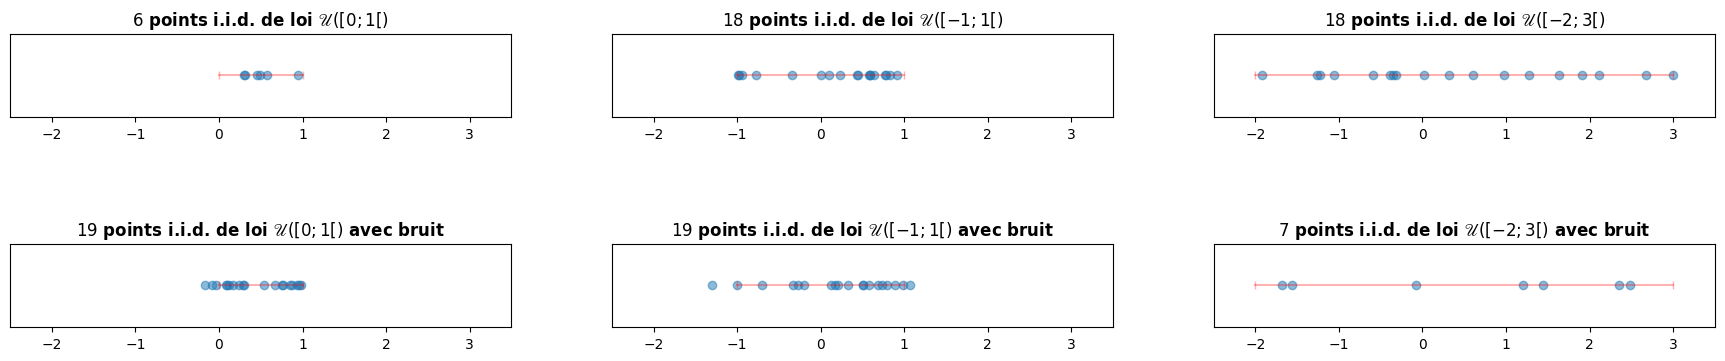

In [343]:
intervalles = [([0], [1]), ([-1], [1]), ([-2], [3])]
cols = 3
rows = (len(intervalles) + cols - 1) // cols

plt.figure(figsize = (22, 5))

N_min, N_max = 3, 20
i = 1
for a, b in intervalles:
    n, d = np.random.randint(low = N_min, high = N_max + 1), 1
    
    P = gen_square_unif(n, d, a = a, b = b)
    x, y = [p[0] for p in P], [0] * n

    axis = plt.subplot(2 * rows, cols, i)
    plt.plot([a[0], b[0]], [0, 0], '|', color = 'r', alpha = 0.3, linestyle = '-')
    plt.scatter(x, y, alpha = 0.5)
    
    plt.xlim(-2.5, 3.5)
    plt.ylim(-0.5, 0.5)
    plt.title("$" + str(n) + "$ points i.i.d. de loi $\mathscr{U}([" + str(a[0]) + " ; " + str(b[0]) + "[)$", weight = 'bold')
    
    axis.axes.yaxis.set_ticklabels([])
    plt.tick_params(left = False)

    plt.gca().set_aspect('equal', adjustable = 'box')
    
    i += 1

for a, b in intervalles:
    n, d = np.random.randint(low = N_min, high = N_max + 1), 1
    
    P = gen_square_unif(n, d, noise = 0.5, a = a, b = b)
    x, y = [p[0] for p in P], [0] * n

    axis = plt.subplot(2 * rows, cols, i)
    plt.plot([a[0], b[0]], [0, 0], '|', color = 'r', alpha = 0.3, linestyle = '-')
    plt.scatter(x, y, alpha = 0.5)
    
    plt.xlim(-2.5, 3.5)
    plt.ylim(-0.5, 0.5)
    plt.title("$" + str(n) + "$ points i.i.d. de loi $\mathscr{U}([" + str(a[0]) + " ; " + str(b[0]) + "[)$ avec bruit", weight = 'bold')
    
    axis.axes.yaxis.set_ticklabels([])
    plt.tick_params(left = False)

    plt.gca().set_aspect('equal', adjustable = 'box')
    
    i += 1

plt.show()

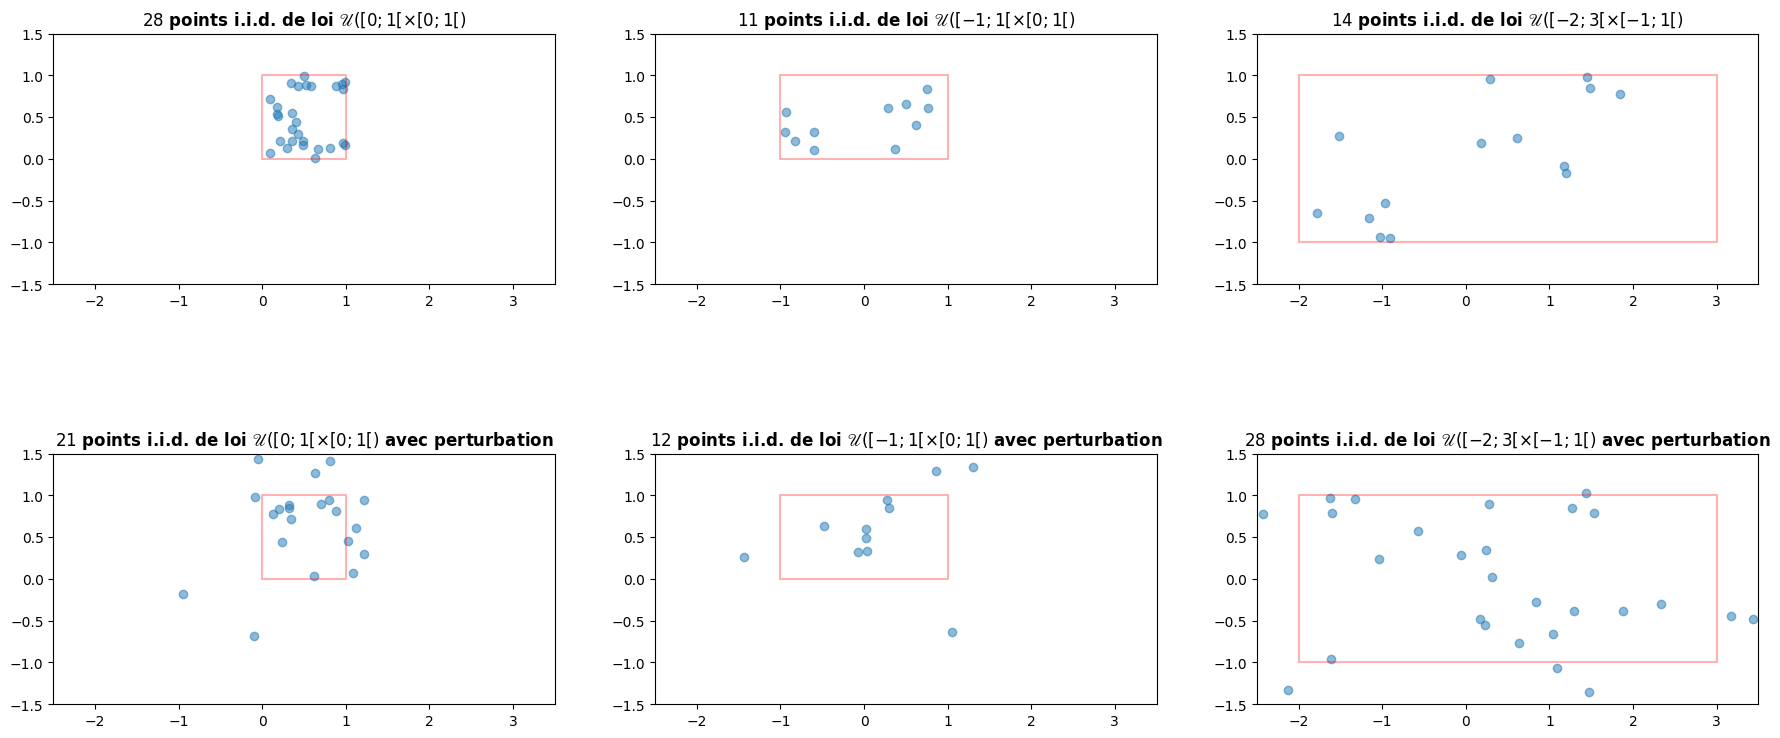

In [344]:
intervalles = [([0, 0], [1, 1]), ([-1, 0], [1, 1]), ([-2, -1], [3, 1])]
cols = 3
rows = (len(intervalles) + cols - 1) // cols

plt.figure(figsize = (22, 10))

N_min, N_max = 10, 30
i = 1
for a, b in intervalles:
    n, d = np.random.randint(low = N_min, high = N_max + 1), 2
    
    P = gen_square_unif(n, d, a = a, b = b)
    x, y = [p[0] for p in P], [p[1] for p in P]

    axis = plt.subplot(2 * rows, cols, i)
    plt.plot([a[0], b[0], b[0], a[0], a[0]], [a[1], a[1], b[1], b[1], a[1]], color = 'r', alpha = 0.3, linestyle = '-')
    plt.scatter(x, y, alpha = 0.5)
    
    plt.xlim(-2.5, 3.5)
    plt.ylim(-1.5, 1.5)
    plt.title("$" + str(n) + "$ points i.i.d. de loi $\mathscr{U}([" + str(a[0]) + " ; " + str(b[0]) + "[ \\times [" + str(a[1]) + " ; " + str(b[1]) + "[)$", weight = 'bold')

    plt.gca().set_aspect('equal', adjustable = 'box')
    
    i += 1

for a, b in intervalles:
    n, d = np.random.randint(low = N_min, high = N_max + 1), 2
    
    P = gen_square_unif(n, d, perturbation = 0.5, a = a, b = b)
    x, y = [p[0] for p in P], [p[1] for p in P]

    axis = plt.subplot(2 * rows, cols, i)
    plt.plot([a[0], b[0], b[0], a[0], a[0]], [a[1], a[1], b[1], b[1], a[1]], color = 'r', alpha = 0.3, linestyle = '-')
    plt.scatter(x, y, alpha = 0.5)
    
    plt.xlim(-2.5, 3.5)
    plt.ylim(-1.5, 1.5)
    plt.title("$" + str(n) + "$ points i.i.d. de loi $\mathscr{U}([" + str(a[0]) + " ; " + str(b[0]) + "[ \\times [" + str(a[1]) + " ; " + str(b[1]) + "[)$ avec perturbation", weight = 'bold')

    plt.gca().set_aspect('equal', adjustable = 'box')
    
    i += 1

plt.show()

### **3.2.3 $-$ Random generation of clusters**

Pour ce deuxième type de jeu de donnée, nous allons générer des _clusters_ circulaires dans $\R^d$ avec ou sans bruit comme c'est le cas dans les **figures $5$ et $6$** de l'énoncé. La génération aléatoire de points uniformément répartis dans une hypersphère de dimension $d$ est subtile et requiert un peu de travail, nous nous somme appuyés sur la page : [https://baezortega.github.io/2018/10/14/hypersphere-sampling/](https://baezortega.github.io/2018/10/14/hypersphere-sampling/ "Sampling in the hypersphere")

In [345]:
def gen_cluster_circular_unif(n: int,
                              d: int,
                              num_cluster: int,
                              radius: list[float],
                              perturbation: Optional[float] = None,
                              noise: Optional[float] = None,
                              a: Optional[list[float]] = None,
                              b: Optional[list[float]] = None,
                              weights: Optional[list[float]] = [0.7, 0.3]) -> tuple[Ensemble, Ensemble]:
    '''
        Générer des clusters circulaires de points répartis uniformément au sein de ces clusters.
        Voir : - https://stackoverflow.com/questions/5408276/sampling-uniformly-distributed-random-points-inside-a-spherical-volume
               - https://baezortega.github.io/2018/10/14/hypersphere-sampling/
    '''
    if a is None or b is None: a, b = np.zeros(shape = (1, d), dtype = float), np.ones(shape = (1, d), dtype = float)
    else: a, b = np.reshape(a, newshape = (1, d)), np.reshape(b, newshape = (1, d))

    # Centre des clusters.
    centres = np.random.rand(num_cluster, d) * (b - a) + a
    rayons = np.power(np.random.rand(n, 1), 1. / d)
    mask = np.random.choice(range(num_cluster), size = n)

    # Tirage de n points uniformément sur la sphère unité de R^d.
    S = np.random.randn(n, d)
    S /= np.linalg.norm(S, axis = 1).reshape(-1, 1)

    S = centres[mask] + (S * rayons) * np.array(radius).reshape(-1, 1)[mask]
    return (add_noise_and_perturbation(S, d, perturbation, noise, a, b, weights), centres.tolist())

Voici quelques exemples de génération aléatoire de points, nous affichons les disques utilisés pour les clusters en rouge (très transparent) : 

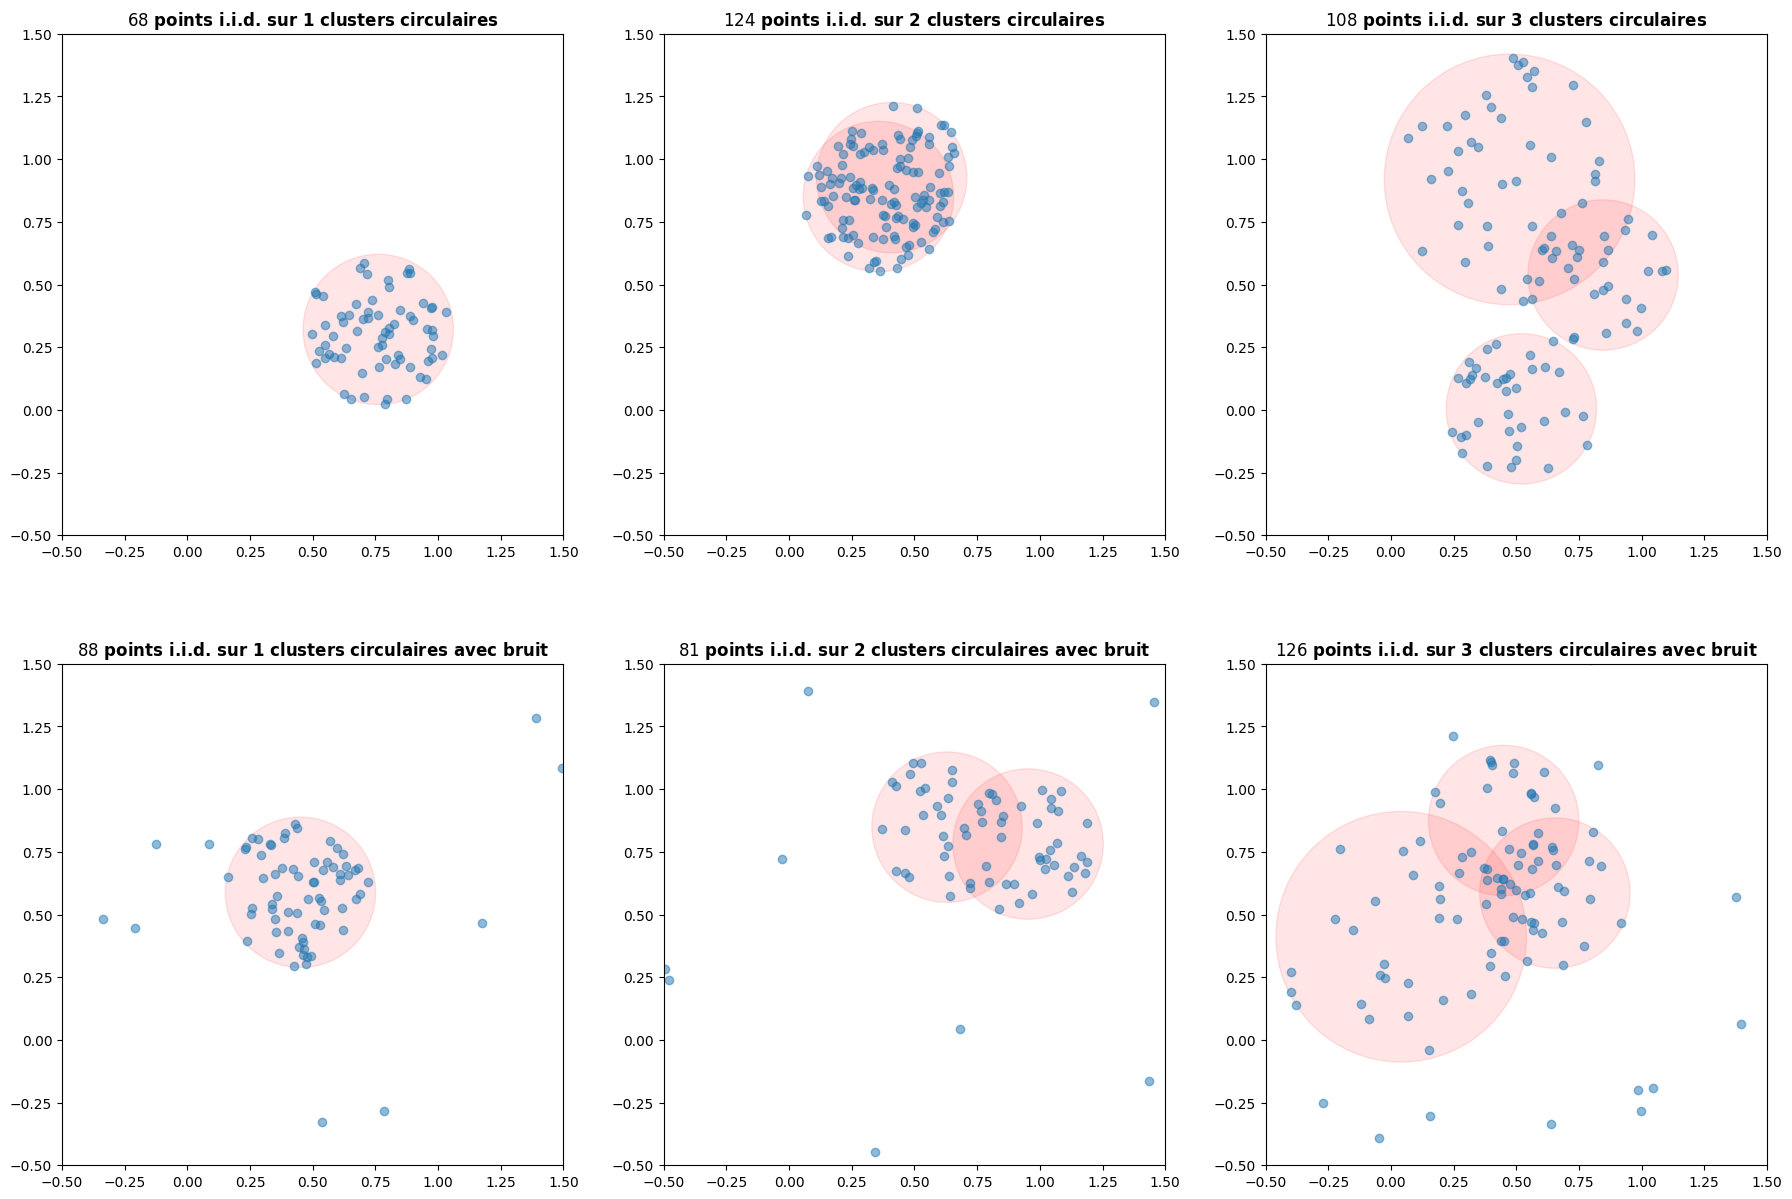

In [346]:
radius = [[0.3], [0.3, 0.3], [0.3, 0.5, 0.3]]
cols = 3
rows = (len(intervalles) + cols - 1) // cols

plt.figure(figsize = (22, 15))

N_min, N_max = 50, 150
i = 1
for R in radius:
    n, d = np.random.randint(low = N_min, high = N_max + 1), 2
    
    P, centres = gen_cluster_circular_unif(n, d, num_cluster = len(R), radius = R)
    x, y = [p[0] for p in P], [p[1] for p in P]

    axis = plt.subplot(2 * rows, cols, i)
    for r, c  in zip(R, centres):
        plt.gca().add_patch(plt.Circle(c, r, color = 'r', alpha = 0.1, linestyle = '-'))
    plt.scatter(x, y, alpha = 0.5)
    
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    plt.title("$" + str(n) + "$ points i.i.d. sur " + str(len(R)) + " clusters circulaires", weight = 'bold')
    
    plt.gca().set_aspect('equal', adjustable = 'box')

    i += 1

for R in radius:
    n, d = np.random.randint(low = N_min, high = N_max + 1), 2
    
    P, centres = gen_cluster_circular_unif(n, d, num_cluster = len(R), noise = 1., radius = R)
    x, y = [p[0] for p in P], [p[1] for p in P]

    axis = plt.subplot(2 * rows, cols, i)
    for r, c  in zip(R, centres):
        plt.gca().add_patch(plt.Circle(c, r, color = 'r', alpha = 0.1, linestyle = '-'))
    plt.scatter(x, y, alpha = 0.5)
    
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    plt.title("$" + str(n) + "$ points i.i.d. sur " + str(len(R)) + " clusters circulaires avec bruit", weight = 'bold')
    
    plt.gca().set_aspect('equal', adjustable = 'box')

    i += 1

plt.show()

### **3.2.4 $-$ Random uniform points along a polygonal curve**

Une autre possibilité pour créer des jeux de donnée est de générer aléatoirement et uniformément des points sur une lignes polygonale. Une petite perturbation gaussienne nous permettra d'obtenir des distributions de points semblables à la **figure $7$** de l'énoncé par exemple.

Nous représentons simplement une ligne polygonale de $\R^d$ par une liste de points de $\R^d$. Une ligne polygonale peut-être fermée ou non, ce qui se traduit par la répétition ou non, en fin de liste, du premier point. Afin de tirer uniformément des points sur cette ligne polygonale, notre stratégie est d'affecter à chaque segment un _poids_ qui n'est autre que le ratio $\frac{\ell}{L}$ entre la longueur $\ell$ de ce segment et la longueur $L$ de la ligne polygonale. Une fois le tirage pondéré effectué, nous tirerons une seconde loi uniforme sur $\intfo{0}{1}$ afinde placer le point sur le segment choisi.

In [347]:
def gen_polygonal_line_unif(n: int,
                            d: int,
                            line: Ensemble,
                            perturbation: Optional[float] = None,
                            noise: Optional[float] = None,
                            weights: Optional[list[float]] = [0.7, 0.3]) -> Ensemble:
    '''
        Générer uniforme de points sur une ligne polygonale.
    '''
    line = np.array(line)

    vecteurs = np.diff(line, axis = 0)
    poids = np.linalg.norm(vecteurs, axis = 1)
    poids /= np.sum(poids)

    indices_sommets = np.random.choice(range(len(vecteurs)), size = n, p = poids)
    rapport = np.random.rand(n, 1)

    S = line[indices_sommets] + vecteurs[indices_sommets] * rapport

    a, b = S.min(axis = 1).reshape(n, 1), S.max(axis = 1).reshape(n, 1)
    return add_noise_and_perturbation(S, d, perturbation, noise, a, b, weights)

Voici quelques exemples de génération aléatoire de points, nous affichons la lignes polygonale en rouge (très transparent) : 

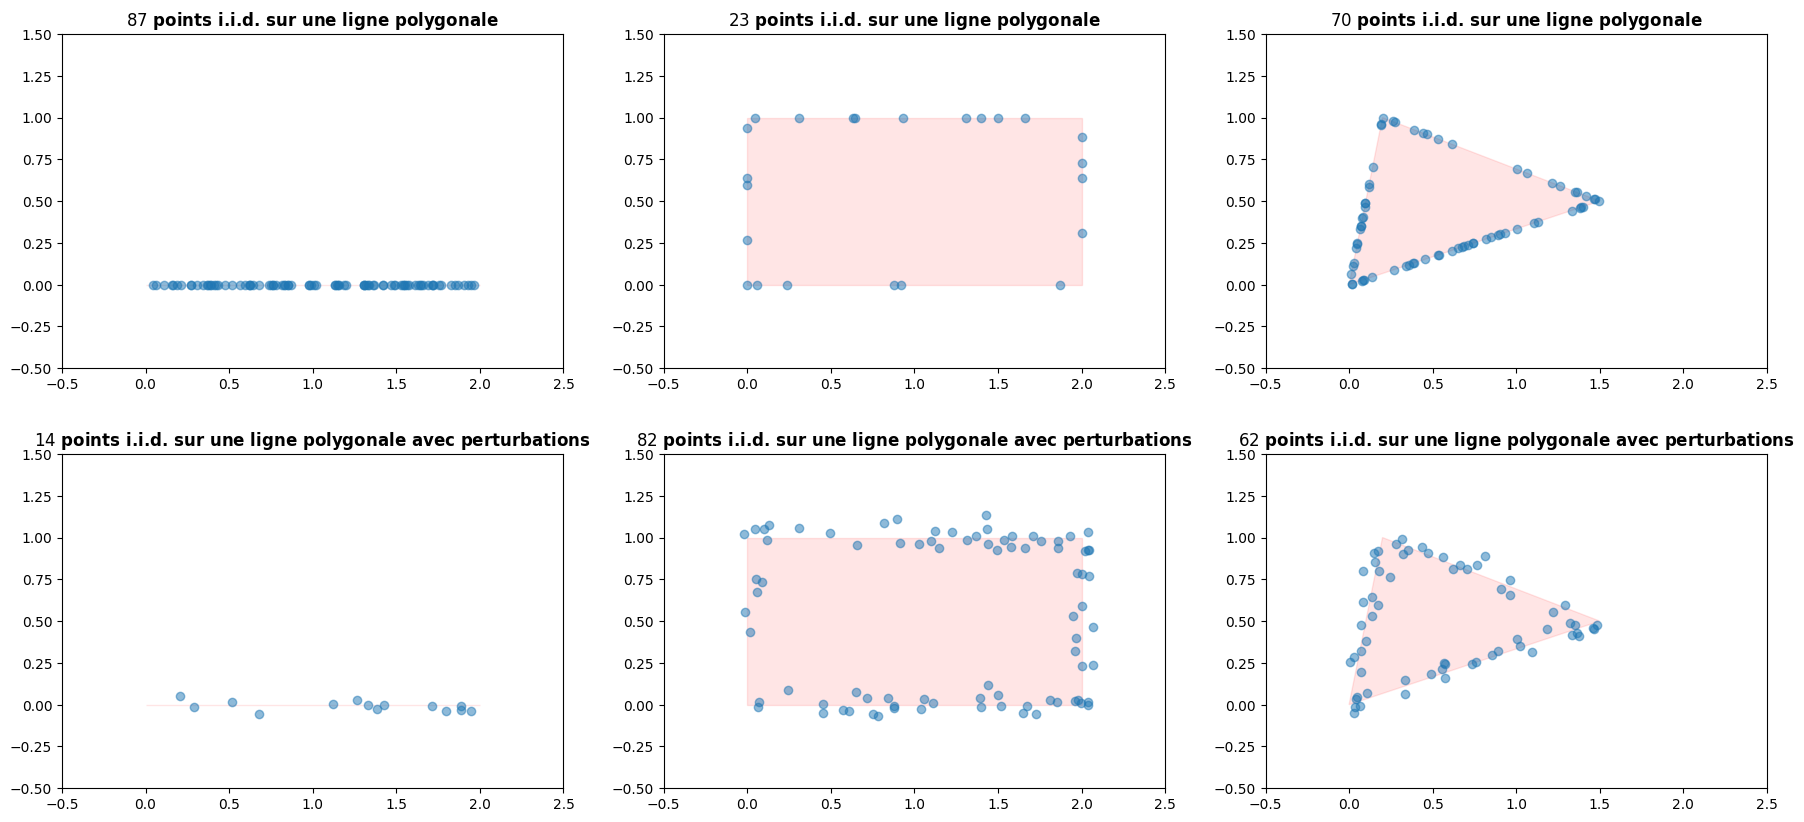

In [348]:
lignes = [[[0., 0.], [2., 0.]], [[0., 0.], [2., 0.], [2., 1.], [0., 1.], [0., 0.]], [[0., 0.], [1.5, 0.5], [0.2, 1], [0., 0.]]]
cols = 3
rows = (len(lignes) + cols - 1) // cols

plt.figure(figsize = (22, 10))

N_min, N_max = 10, 100
i = 1
for L in lignes:
    n, d = np.random.randint(low = N_min, high = N_max + 1), 2
    
    P = gen_polygonal_line_unif(n, d, line = L)
    x, y = [p[0] for p in P], [p[1] for p in P]

    axis = plt.subplot(2 * rows, cols, i)
    plt.gca().add_patch(plt.Polygon(L, color = 'r', alpha = 0.1, linestyle = '-'))
    plt.scatter(x, y, alpha = 0.5)
    
    plt.xlim(-0.5, 2.5)
    plt.ylim(-0.5, 1.5)
    plt.title("$" + str(n) + "$ points i.i.d. sur une ligne polygonale", weight = 'bold')
    
    plt.gca().set_aspect('equal', adjustable = 'box')

    i += 1

for L in lignes:
    n, d = np.random.randint(low = N_min, high = N_max + 1), 2
    
    P = gen_polygonal_line_unif(n, d, line = L, perturbation = 0.04)
    x, y = [p[0] for p in P], [p[1] for p in P]

    axis = plt.subplot(2 * rows, cols, i)
    plt.gca().add_patch(plt.Polygon(L, color = 'r', alpha = 0.1, linestyle = '-'))
    plt.scatter(x, y, alpha = 0.5)
    
    plt.xlim(-0.5, 2.5)
    plt.ylim(-0.5, 1.5)
    plt.title("$" + str(n) + "$ points i.i.d. sur une ligne polygonale avec perturbations", weight = 'bold')
    
    plt.gca().set_aspect('equal', adjustable = 'box')

    i += 1

plt.show()

---

## **3.3 $-$ Benchmarking**

### **3.3.1 $-$ Creating the datasets for benchmarking**

La fonction ci-dessous se charge de créer des jeux de données dans le répertoire ```datasets```.

In [349]:
def generate_datasets(N: int,
                      range_points: Optional[list] = [10, 500],
                      p_noise: Optional[float] = 0.4,
                      p_perturbations: Optional[float] = 0.6,
                      save: Optional[bool] = True,
                      noms: Optional[list] = None) -> tuple[list[Ensemble], list[str]]:
    '''
        Génère N datasets avec une certaine probabilité de présence de bruit et de perturbations.
    '''
    q, r = N // 3, N % 3
    datasets = []

    if noms == None:
        noms = list(map(str, range(N)))

    for _ in range(q):
        noise_min, noise_max = 0.5, 0.8
        perturbation_min, perturbation_max = 0.1, 0.5
        nb_points = np.random.randint(low = range_points[0], high = range_points[1])

        perturbation = 0.
        if rd.random() <= p_perturbations:
            perturbation = np.random.random() * (perturbation_max - perturbation_min) + perturbation_min

        noise = 0.
        if rd.random() <= p_noise:
            noise = np.random.random() * (noise_max - noise_min) + noise_min

        datasets.append(homothetie(gen_square_unif(nb_points, 2, a = [0, 0], b = [1, 1], perturbation = perturbation, noise = noise, weights = [0.7, 0.3]), [0, 0], r = np.random.randint(1000, 2500)))

    
    for _ in range(q + r):
        noise_min, noise_max = 0.5, 0.8
        perturbation_min, perturbation_max = 0.01, 0.07
        nb_points = np.random.randint(low = range_points[0], high = range_points[1])

        perturbation = 0.
        if rd.random() <= p_perturbations:
            perturbation = np.random.random() * (perturbation_max - perturbation_min) + perturbation_min

        noise = 0.
        if rd.random() <= p_noise:
            noise = np.random.random() * (noise_max - noise_min) + noise_min
    
        datasets.append(homothetie(gen_cluster_circular_unif(nb_points, 2, 3, [0.1, 0.1, 0.1], a = [0, 0], b = [1, 1], perturbation = perturbation, noise = noise, weights = [0.7, 0.3])[0], [0, 0], r = np.random.randint(1000, 2500)))

                        
    for _ in range(q):
        noise_min, noise_max = 0.5, 0.8
        perturbation_min, perturbation_max = 0.009, 0.015
        nb_points = np.random.randint(low = range_points[0], high = range_points[1])

        perturbation = 0.
        if rd.random() <= p_perturbations:
            perturbation = np.random.random() * (perturbation_max - perturbation_min) + perturbation_min

        noise = 0.
        if rd.random() <= p_noise:
            noise = np.random.random() * (noise_max - noise_min) + noise_min

        L = gen_square_unif(np.random.randint(low = 2, high = 10), 2, a = [0, 0], b = [1, 1], perturbation = 0., noise = 0., weights = [0.7, 0.3])
        datasets.append(homothetie(gen_polygonal_line_unif(nb_points, 2, L, perturbation = perturbation, noise = noise, weights = [0.7, 0.3]), [0, 0], r = np.random.randint(1000, 2500)))
    
    
    if save:
        noms = [save_dataset(nom, P) for nom, P in zip(noms, datasets)]
    
    return datasets, noms

Nous allons maintenant générer nos jeus de données

In [350]:
ranges = [[5, 20], [30, 80], [100, 200], [300, 500], [500, 1_000], [1_500, 3_000], [5_000, 10_000]]
N = 3 # Nombre de datasets à générer
i = 0
for range_points in ranges:
    generate_datasets(N, range_points = range_points, noms = list(map(str, range(i, i + N))))
    i += N

# To hide the output
;

''

---

### **3.3.2 $-$ Benchmarking functions**

La fonction ci-dessous, trouvée sur le forum _Stack Overflow_ permet defixer une limite de temps à l'éxécution d'une fonction.

In [351]:
class TimeoutException(Exception):
    pass

In [352]:
# Source de la fonction : https://stackoverflow.com/a/13821695
def timeout(func, args = (), kwargs = {}, timeout_duration = 1, default = None):
    def handler(signum, frame):
        raise TimeoutException()

    # Set the timeout handler: 
    signal.signal(signal.SIGALRM, handler) 
    signal.alarm(timeout_duration)
    try:
        result = func(*args, **kwargs)
    except TimeoutError as exc:
        result = default
    finally:
        signal.alarm(0)

    return result

Nous définissons une fonction qui nous sera utile pour nos différents tests : 

In [356]:
def benchmark(functions: list[Callable],
              inputs: dict[str, list[list[Any, ...]]],
              time_limit: Optional[float] = 20,
              step_time: Optional[float] = 1,
              repeat: Optional[int] = 5,
              equal: Optional[Callable] = lambda x, y: x == y,
              save: Optional[bool] = True,
              file_name: Optional[str] = 'benchmark.txt') -> tuple[list[list[Any, ...]], list[list[float, ...]]]:
    '''
        Cette fonction se charge de tester des fonctions sur chaque entrée fournies.
        Chaque test (appliquer une fonction sur une entrée) est évalué un certain nombre de fois 
        (5 fois par défaut) avec un temps limite pour chaque exécution (par défaut 20 secondes).
        Entre chaque test, nous faisons une pause de 1 seconde.

        Renvoie deux matrices, d'une des résultats (une fonction par ligne, un input par colonne) et 
        la seconde, la matrice des durées moyennes d'exécution correspondantes.
    '''
    resultats, temps = [], []

    header = "function_name, n, k, dataset_name, average_time, result\n\n"
    fichier = None
    if save:
        fichier = open(file_name, mode = 'w+', encoding = 'utf-8')
        fichier.write(header)
    
    for function in functions:
        resultats.append([])
        temps.append([])

        for i, (key, input) in enumerate(inputs.items()):
            sleep(step_time)
            print("Running function " + function.__name__ + " on input " + str(i) + "...")

            temps_total = 0
            resultat = None
            try:
                for _ in range(repeat):
                    t1 = time()
                    resultat = timeout(function, args = input, timeout_duration = time_limit)
                    t2 = time()
                    
                    temps_total += t2 - t1
    
            except TimeoutException:
                resultats[-1].append(None)
                temps[-1].append(None)
            else:
                if len(resultats) > 1:
                    if any([r[i] != None and not equal(r[i], resultat) for r in resultats[:-1]]): # Faire attention dans le cas de graphe... pas d'ordre pour la liste des voisins...
                        resultat_attendu = str([r[i] for r in resultats[:-1] if r[i] != None][0])
                        raise ValueError("La fonction " + function.__name__ + " a renvoyé le résultat " + str(resultat) + " qui est incorrect ! \nRésultat attendu : " + resultat_attendu)

                resultats[-1].append(resultat)
                temps[-1].append(temps_total / repeat)
                print("Function " + function.__name__ + " terminates successfully!\n")

            if save:
                if len(input) < 3:
                    k = None
                else:
                    k = input[2]
                fichier.write(', '.join([function.__name__, str(len(input[0])), str(k), key, str(temps[-1][-1]), str(resultats[-1][-1])]) + '\n\n')
    
    if save:
        fichier.close()
    
    return (resultats, temps)

### **3.3.3 $-$ Executing the tests...**

Püis, nous lisons chaque dataset et nous lançons nos tests : 

In [355]:
datasets: dict[str, tuple[Ensemble, Point]] = dict()
repertoire = 'datasets/'

# Récupération des jeux de données.
for root, directories, files in os.walk(repertoire):
    for file_name in files:
        if file_name.endswith(".txt"):
            datasets[file_name] = list(load_dataset(root + file_name))

Nous testons les quatres premières fonctions du sujet : 

In [249]:
fonctions = [task_1_queue, task_2_queue_v2, task_3, task_4_finding_only]
inputs = dict()
for key, (P, p_1) in datasets.items():
    i, k = 2, 4
    n = len(P)
    while k < n:
        k = min(n, k + 2 * i + 1)
        i += 1
        inputs[key + '_' + str(k)] = [P, p_1, k]

benchmark(fonctions, inputs, file_name = 'benchmark_0.txt')
;

Running function task_3 on input 0...
Function task_3 terminates successfully!

Running function task_3 on input 1...
Function task_3 terminates successfully!

Running function task_3 on input 2...
Function task_3 terminates successfully!

Running function task_3 on input 3...
Function task_3 terminates successfully!

Running function task_3 on input 4...
Function task_3 terminates successfully!

Running function task_3 on input 5...
Function task_3 terminates successfully!

Running function task_3 on input 6...
Function task_3 terminates successfully!

Running function task_3 on input 7...
Function task_3 terminates successfully!

Running function task_3 on input 8...
Function task_3 terminates successfully!

Running function task_3 on input 9...
Function task_3 terminates successfully!

Running function task_3 on input 10...
Function task_3 terminates successfully!

Running function task_3 on input 11...
Function task_3 terminates successfully!

Running function task_3 on input 12...

KeyboardInterrupt: 

Ici nous testons désormais les fonctions $5$, $6$ et $7$. La tâche $7$ est essentiellement basée sur la fonction ```find_neighbors``` comme la tâche $6$ et, bien que les tâches $6$ et $7$ ait la même complexité temporelle en théorie, en pratique, les résultats d'exécution montrent que la tâche $7$ est plus rapide que la tâche $6$. En effet, dans la tâche $6$, nous parcourons l'ensemble des points de $P$ à chaque appel de ```find_neighbors```, ce qui est plus coûteux que de parcourir seulement (et deux fois) les points déjà présents i.e. la liste ```Q``` qui ne contient pas l'ensemble des points de ```P``` mais dont de taille augmente de $1$ à chaque tour de boucle.

In [275]:
fonctions = [task_5, task_6, task_7_benchmark]
inputs = dict()
for key, (P, p_1) in datasets.items():
    inputs[key] = [P]

benchmark(fonctions, inputs, equal = equal_graph, file_name = 'benchmark_1.txt')
;

Running function task_5 on input 0...
Function task_5 terminates successfully!

Running function task_5 on input 1...
Function task_5 terminates successfully!

Running function task_5 on input 2...
Function task_5 terminates successfully!

Running function task_5 on input 3...
Function task_5 terminates successfully!

Running function task_5 on input 4...
Function task_5 terminates successfully!

Running function task_5 on input 5...
Function task_5 terminates successfully!

Running function task_5 on input 6...
Function task_5 terminates successfully!

Running function task_5 on input 7...
Function task_5 terminates successfully!

Running function task_5 on input 8...
Function task_5 terminates successfully!

Running function task_5 on input 9...
Function task_5 terminates successfully!

Running function task_5 on input 10...
Function task_5 terminates successfully!

Running function task_5 on input 11...
Function task_5 terminates successfully!

Running function task_5 on input 12...

''

---